# E-tivity 2 (10/02/25 - 23/02/25)

* Your Name: Dean McGarr

* Your Student ID: 23317639

## Outline

This e-tivity is split into two parts. The first part <a href="#part1">**Stock Predicition**</a> is a group activity where you are tasked with predicting the stock market.

The second <a href="#part2">**Sentiment Analysis**</a> is an individual task, the problem is to predict if a film review is positive or negative.

### Guidelines

The e-tivity is split into five tasks. The first four are "group" excersises, in that you post the solutions to Tasks 1-4 to the Group Locker. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to Brightspace.

Marks will be deducted if task 5 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-5 and with correct identification or filename.


Grading guidelines: the rubrics for the e-tivity are here https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=49284&rubricId=2621&originTool=quicklinks




<a id='part1'></a>
## Stock Prediction

### Context

There is a small dataset of real stock prices for each working day from the end of 2015 to the end of 2019. There are four variables (with a time stamp), stock price, oil price, gold price and Euro to Dollar exchange. You need to predict the Stock price a day ahead from only the past values of each of the 4 variables.


### Tasks 1-4 (complete by Sunday 16/02/25)

These tasks are to be completed and uploaded to GitLab on which the other group members can comment. The forum activity will form part of the overall mark for the e-tivity.

**Task 1: data preprocessing**

Explain any preprocessing steps you take including but limited to reformatting and also how you have selected the training and test sets. The test set should be 20% of the whole.


**Task 2: data cleaning**

There are a number of missing values in the data. Clean the data so that it is suitable for use with the NN. Bare in mind that you want to retain the time coherency of the data as much as possible. Explain the steps you have taken.


In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/stock.csv"
X = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')  # Set 'Date' as index

# 1. Check the shape (number of rows and columns)
print("Shape of the dataset:", X.shape)

# 2. View basic information about the dataset
print("\nDataset info:")
X.info()

# 3. View a summary of the dataset
print("\nSummary statistics:")
print(X.describe(include="all"))  # Includes stats for numeric, categorical, and other data types

# Check for missing values
print("Missing values per column:\n", X.isnull().sum())

# Check for duplicate rows
print("Number of duplicate rows:", X.duplicated().sum())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of the dataset: (1033, 4)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1033 entries, 2015-11-23 to 2019-12-31
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Stock         1033 non-null   float64
 1   Oil           1023 non-null   float64
 2   EuroToDollar  1021 non-null   float64
 3   Gold          1033 non-null   float64
dtypes: float64(4)
memory usage: 40.4 KB

Summary statistics:
             Stock          Oil  EuroToDollar         Gold
count  1033.000000  1023.000000   1021.000000  1033.000000
mean   2537.063011    53.655484      0.883818  1353.312488
std     338.853458     9.799842      0.034394    89.592361
min    1833.400024    27.299999      0.800800  1090.200000
25%    2204.969971    47.594999      0.859700  1303.800000
50%    2584.000000    53.0

In [16]:
# Deal with missing values by taking average of previous day and following day, this is the most
for col in ["Oil", "EuroToDollar"]:
    X[col] = X[col].interpolate(method='linear')

# Check again for missing values
print("Missing values after interpolation:\n", X.isnull().sum())

# 3. View a summary of the dataset
print("\nSummary statistics:")
print(X.describe(include="all"))  # Includes stats for numeric, categorical, and other data types

Missing values after interpolation:
 Stock           0
Oil             0
EuroToDollar    0
Gold            0
dtype: int64

Summary statistics:
             Stock          Oil  EuroToDollar         Gold
count  1033.000000  1033.000000   1033.000000  1033.000000
mean   2537.063011    53.628669      0.883865  1353.312488
std     338.853458     9.844134      0.034292    89.592361
min    1833.400024    27.299999      0.800800  1090.200000
25%    2204.969971    47.580002      0.859800  1303.800000
50%    2584.000000    53.049999      0.887600  1346.500000
75%    2811.350098    60.549999      0.904600  1403.900000
max    3247.229980    76.180000      0.963900  1584.500000


**Task 3: model construction**

Construct a RNN network that will predict the future value of Stock, one day/time inteval in advance.

In [17]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert data to sequences
def create_sequences(data, target_index, seq_length=5):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])  # Use past `seq_length` days as input
        y_seq.append(data[i+seq_length, target_index])  # Predict next day’s Stock
    return np.array(X_seq), np.array(y_seq)

seq_length = 5  # Using past 5 days to predict the next day
target_index = 0  # 'Stock' is at index 0

X_seq, y_seq = create_sequences(X_scaled, target_index, seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Build the RNN model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[1])),
    LSTM(50, activation='relu'),
    Dense(25),
    Dense(1)  # Predicting one value (next day’s Stock)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Predict future stock values
y_pred = model.predict(X_test)

# Inverse transform to get actual values
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], X.shape[1] - 1)))))[:, 0]

# Print sample predictions
print("Sample predictions:", y_pred_actual[:5])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1005 - val_loss: 0.0252
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036 - val_loss: 0.0141
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.8562e-04 - val_loss: 0.0013
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7272e-04 - val_loss: 6.2582e-04
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2308e-04 - val_loss: 6.7180e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4307e-04 - val_loss: 5.6935e-04
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4208e-04 - val_loss: 7.2089e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4003e-04 - val_loss: 5.6919e-04
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8024e-04 - val_loss: 6.5370e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5999e-04 - val_loss: 5.8411e-04
Epoch 12/50
52/52 

**Task 4: test**

Evaluate the model on the test set and display any change in accuracy over time, if any. Test for common issues found in deep learning models.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Mean Squared Error (MSE): 960.7530
Mean Absolute Error (MAE): 22.7797


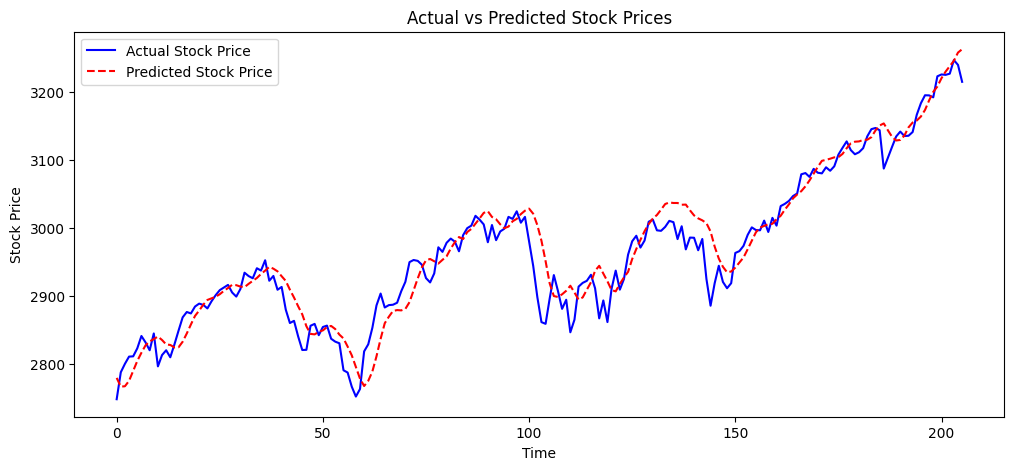

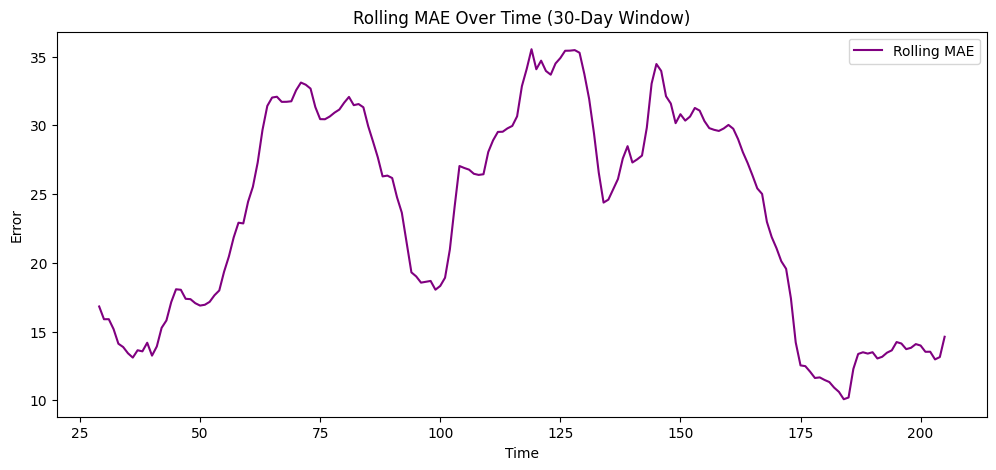

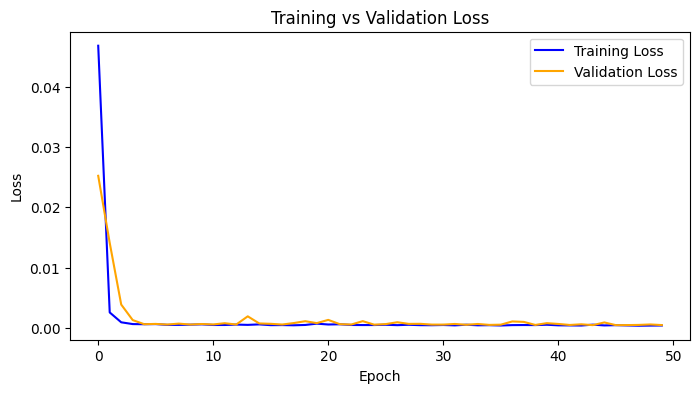

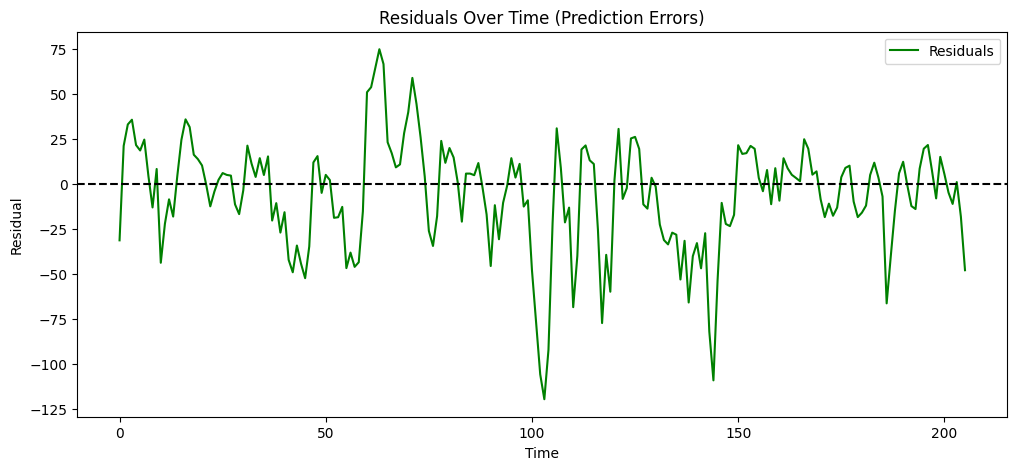

In [18]:
# Predict on test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], X.shape[1] - 1)))))[:, 0]
y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], X.shape[1] - 1)))))[:, 0]

# Compute metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot actual vs. predicted values over time
plt.figure(figsize=(12, 5))
plt.plot(y_test_actual, label="Actual Stock Price", color='blue')
plt.plot(y_pred_actual, label="Predicted Stock Price", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

# Rolling error to check accuracy drift over time
rolling_window = 30  # 30-day rolling error
rolling_mae = pd.Series(abs(y_test_actual - y_pred_actual)).rolling(rolling_window).mean()

plt.figure(figsize=(12, 5))
plt.plot(rolling_mae, label="Rolling MAE", color='purple')
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Rolling MAE Over Time (30-Day Window)")
plt.legend()
plt.show()

# Compare training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="Training Loss", color='blue')

# Check if 'val_loss' exists
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label="Validation Loss", color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Check autocorrelation in residuals
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(12, 5))
plt.plot(residuals, label="Residuals", color='green')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("Residuals Over Time (Prediction Errors)")
plt.legend()
plt.show()


### Post (complete by Sunday 16/02/25)

Post your solution to Tasks 1-4 in notebook form. If you have not completed all the tasks then that is acceptable. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should reference Task 5.

### Respond (complete by Wednesday 19/02/25)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

Grading guidelines for the forum posts: the rubrics for the e-tivity are here https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=49284&rubricId=2621&originTool=quicklinks


<a id='part2'></a>
## Sentiment Analysis


This task is a individual task and should **not** to be uploaded to the Group Locker. No posts should be given via the forums. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Brightpsace.

### Context

You have a model that predicts the sentiment of a film review (positive or negative) from the IMDB. There are two hyperparameters that format the data from IMDB: the maximum review length and the dictionary size. Below is a RNN model that predicts sentiment values.


### Task 5:  (completed by Sunday 25/02/24)

Keeping top_words, max_review_lenngth and the embedding_vector_length the same, change the model so that it uses attention only, i.e. there are no recurrent components. The only Keras layers (defined here https://www.tensorflow.org/api_docs/python/tf/keras/layers) that you allowed to use are:
- Input,
- Embedding,
- Dense,
- Any Attention (must be at leat one),
- TimeDistributed,
- Any Merging,
- Any Reshaping,
- Any Pooling,
- Dropout.

You need not use any of the layers (except attention) but you can use some more than once. Can you do at least as good as the RNN example?

**NB** There are many examples of using attention for sentiment analysis but we looking to see if you can construct a sensible model. The model will be delibrately restricted, so do not waste too much time achieving spectacular accuracy. Remember the rules of thumb that we discussed in the Introduction to DL module.


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

top_words = 100
(Rev_train, Sc_train), (Rev_test, Sc_test) = imdb.load_data(num_words=top_words)

max_review_length = 500
X_train = sequence.pad_sequences(Rev_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(Rev_test, maxlen=max_review_length)
print(X_train.shape)

In [ ]:
embedding_vector_length = 16
model_imdb = Sequential()
model_imdb.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_imdb.add(Dropout(0.2))
model_imdb.add(LSTM(10))
model_imdb.add(Dropout(0.2))
model_imdb.add(Dense(1, activation='sigmoid'))
model_imdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_imdb.summary())
plot_model(model_imdb,show_shapes=True)


The history for the model above has been saved, as it takes a while to run. If you want to run it yourself then comment out the second line.


In [ ]:
nepoch = 150
#IMDB_history = model_imdb.fit(X_train,Sc_train,validation_data=(X_test,Sc_test),epochs=nepoch,batch_size=256)
IMDB_history=np.load('IMDBTrainhist.npy',allow_pickle='TRUE').item()
plt.plot(range(nepoch),IMDB_history['loss'],c='r')
plt.plot(range(nepoch),IMDB_history['val_loss'],c='b')
plt.plot()

In [ ]:
plt.plot(range(nepoch),IMDB_history['accuracy'],c='r')
plt.plot(range(nepoch),IMDB_history['val_accuracy'],c='b')
plt.plot()

### Final Submission (complete by Sunday 23/02/25)

Submit Tasks 1-5 in a single notebook this before the deadline on Sunday.


In [ ]:
## Add additional code cells to implememt the tasks stated above

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.